In [1]:
import numpy as np
import pylab as plt
import torch

import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

The logic is the following:

We approximate the precision matrix of the inference problem like
$$
Q = W^T A^T D A W
$$
where $W$ is a wavelet transform, $A$ corresponds to correlations, and $D$ is a diagonal matrix.

As a starting point, I can assume that $W$ and $A$ are unit matrices.

For the loss function, we need independent noise realisations $n$, ideally such that $n^T (Q+\Sigma_{prior}^{-1}) n$ is low-variance.

Default could be just Gaussian random noise for now. Otherwise random prior draws.

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
N = 64*100  # Number of samples
z = np.random.rand(N, 32, 32)*10-5
x = z + np.random.randn(N, 32, 32)*1

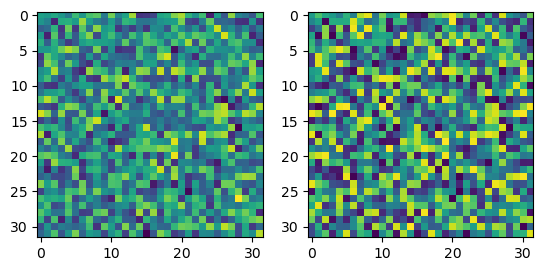

In [4]:
samples = swyft.Samples(x = x, z = z)
plt.subplot(121)
plt.imshow(samples[0]['x'])
plt.subplot(122)
plt.imshow(samples[0]['z'])

In [5]:
class L(torch.nn.Module):
    def __init__(self, logD, W = None, W_T = None, A = None, A_T = None, Q_prior = None):
        super().__init__()
        self.logD = torch.nn.Parameter(logD)
        self.W = W if W else lambda x: x 
        self.W_T = W_T if W else lambda x: x 
        self.A = A if A else lambda x: x
        self.A_T = A_T if A else lambda x: x
        self.Q_prior = Q_prior if Q_prior else lambda x: x*0
        
    @property
    def D(self):
        """Returns diagonal components of D."""
        return torch.exp(self.logD)
    
    def Q(self, x):
        """Applies Q = W.T A.T D A W."""
        x = self.W(x)
        x = self.A(x)
        x = self.D*x
        x = self.A_T(x)
        x = self.W_T(x)
        return x
    
    def __call__(self, z_est, z):
        #print("z_est, z =", z_est.shape, z.shape)
#        N = torch.randn(64, 32, 32)
        N = z[torch.randperm(len(z))]
        #print("N =", N.shape)
        #print("Q(z) =", self.Q(z-z_est).shape)
        loss = 0.5*((self.Q(z-z_est)+self.Q_prior(z-z_est))*N)**2 - self.Q(N)*N
        loss = loss.reshape(-1)
        return swyft.AuxLoss(loss, 'x')

class Network(swyft.AdamWReduceLROnPlateau, swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 1e-2
        self.estimator = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),  # add color dimension
            torch.nn.Conv2d(1, 1, 3, padding=1),
#            torch.nn.Conv2d(1, 128, 3, padding=1),
#            torch.nn.ReLU(),
#            torch.nn.Conv2d(128, 128, 3, padding=1),
#            torch.nn.ReLU(),
#            torch.nn.Conv2d(128, 1, 3, padding=1),
            torch.nn.Flatten(0, 1),  # remove color dimension
        )
        W = torch.nn.Flatten(1, 2)
        W_T = torch.nn.Unflatten(1, (32, 32))
        self.L = L(-10*torch.ones(32*32), W = W, W_T = W_T)

    def forward(self, A, B):
        x = A['x'][:64]
        z_est = self.estimator(x)
        z = B['z'][:64]
        return self.L(z_est, z)

In [6]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64, max_epochs = 10)
dm = swyft.SwyftDataModule(samples, batch_size=64)
network = Network()
trainer.fit(network, dm)

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/weniger/.conda/envs/lensing/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_preci

Sanity Checking: 0it [00:00, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Reloading best model: /gpfs/home2/weniger/swyft/notebooks/dev/lightning_logs/version_4496361/checkpoints/epoch=6-step=560-v2.ckpt


tensor([1.1513, 1.0961, 1.0853,  ..., 1.1604, 1.0595, 1.0865],
       dtype=torch.float64, grad_fn=<ExpBackward0>)


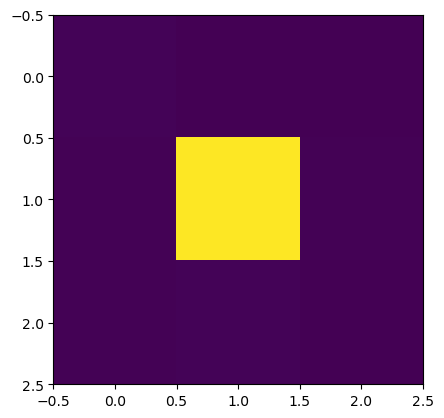

In [7]:
plt.imshow(network.estimator[1].weight.detach().numpy()[0,0])
print(network.L.D)

The GEDA sampler should directly provide noise sampels from the images, without intermediate steps or transformations.

- $U_2$, $D_2$ and $U_2^T$ are all defined in real space, going from $(N, N, N) \rightarrow (N*N*N,)$ and back
- The same is true for $G_1$ etc.

Consequences for GEDA:
- $\theta$ is in image space (updated according to coupling-strength constrained prior)
- $u_1$ is in in image space (updated according to coupling strength)
- $u_2$ is in vector space of $Q_1$ (updated according to likelihood precision)

In [19]:
U2 = torch.nn.Flatten(-2)
U2T = torch.nn.Unflatten(-1, (32, 32))
D2 = torch.ones(32*32)*100
D1 = network.L.D.cpu().detach()
#print(D1.mean(), D1.shape)
G1 = torch.nn.Flatten(-2)
G1T = torch.nn.Unflatten(-1, (32, 32))
sampler = swyft.utils.GEDASampler2(1e-1, G1, D1, G1T, U2, D2, U2T, out_shape = (32, 32))
s = sampler.sample(1, steps=100, initialize_with_Q2=True)[0]

tensor(-0.0038, dtype=torch.float64) tensor(0.0986, dtype=torch.float64)


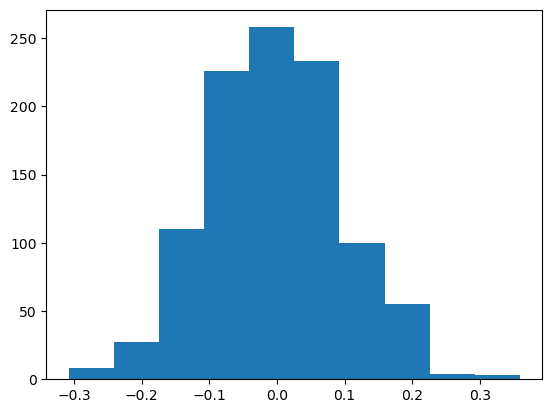

In [20]:
#plt.plot(s)
#s.std()
plt.hist(s.flatten());
print(s.mean(), s.std())

In [103]:
def hartley(x, dim = None):
    """A symmetric Hartley transform.
    
    H(H(x)) = x
    """
    fx = torch.fft.fftn(x, dim = dim)
    return (fx.real - fx.imag)*0.5

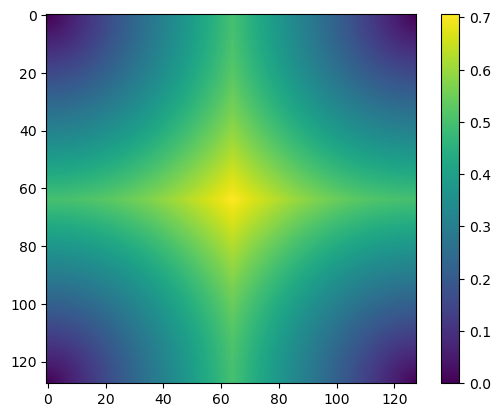

In [104]:
def get_k_grid(n):
    k = torch.fft.fftfreq(n)
    kX, kY = torch.meshgrid(k, k)
    K = (kX**2 + kY**2)**0.5
    return K

K = get_k_grid(128)
plt.imshow(K)
plt.colorbar()

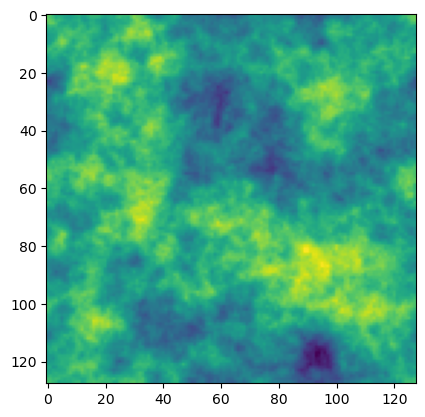

In [105]:
x = (K+0.01)**-1.8*torch.randn(128, 128)
hx = hartley(x)
plt.imshow(hx)